In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np

torch.manual_seed(1)

from tqdm import tqdm_notebook as tqdm
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

## Load data
source is https://www.kaggle.com/c/word2vec-nlp-tutorial/data

In [6]:
data_path = '/Users/tyler/Documents/programming/pytorch_nlp/data/word2vec-nlp-tutorial/'

In [7]:
df = pd.read_csv(data_path+'labeledTrainData.tsv',sep='\t')

In [12]:
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [93]:
train = df[:15000]
val = df[15000:20000]
test = df[20000:]

In [95]:
len(train),len(val),len(test)

(15000, 5000, 5000)

In [96]:
def process_review(review):
    chars = ['/','\\','>','<','-','br']
    chars.extend('1 2 3 4 5 6 7 8 9 0'.split())
    for char in chars:
        review = review.replace(char,'')
    
    tokens = word_tokenize(review)
    tokens = [t.lower() for t in tokens]
    return tokens

## Make vocab and train data

In [97]:
labels = list(train.sentiment)
reviews = list(train.review.values)

all_words = [process_review(review) for review in tqdm(reviews)]

train_data = list(zip(all_words,labels))

/Users/tyler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [98]:
flat_list = [item for sublist in all_words for item in sublist]
vocab = set(flat_list)

len(vocab)

word_to_idx = {word:idx for idx,word in enumerate(list(vocab))}

counts = Counter(flat_list)

In [99]:
idx_to_word = {idx:word for word,idx in word_to_idx.items()}

## Make validation and test data

In [100]:
labels = list(test.sentiment)
reviews = list(test.review.values)

all_words = [process_review(review) for review in tqdm(reviews)]

test_data = list(zip(all_words,labels))

/Users/tyler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [101]:
labels = list(val.sentiment)
reviews = list(val.review.values)

all_words = [process_review(review) for review in tqdm(reviews)]

val_data = list(zip(all_words,labels))

/Users/tyler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


## Set up model

In [102]:
class BoWClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)


    def forward(self, bow_vec):
        return F.log_softmax(self.linear(bow_vec), dim=1)

In [103]:
def make_target(label, label_to_ix):
    return torch.LongTensor([label_to_ix[label]])

def make_bow_vector(sentence, word_to_idx):
    vec = torch.zeros(len(word_to_idx))
    for word in sentence:
        if word in word_to_idx:
            vec[word_to_idx[word]] += 1
    return vec.view(1, -1)

In [104]:
VOCAB_SIZE = len(word_to_idx)
NUM_LABELS = 2
model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)

In [105]:
vec = make_bow_vector('this is a sentence'.split(),word_to_idx)

In [106]:
vec.sum()

tensor(4.)

In [107]:
label_to_idx = {'negative': 0, 'positive': 1}
idx_to_label = {0:'negative', 1:'positive'}

In [108]:
with torch.no_grad():
    sample = all_words[0]
    bow_vector = make_bow_vector(sample[0], word_to_idx)
    log_probs = model(bow_vector)
    print(log_probs)

tensor([[-0.6869, -0.6994]])


## Train

In [109]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [117]:
save_path = 'model_checkpoints/bow.pt'
val_loss_min = np.Inf

num_epochs = 10
loss_history = []
for epoch in range(num_epochs):
    train_loss = []
    for sentence, label in train_data:
        model.zero_grad()

        vec = make_bow_vector(sentence, word_to_idx)
        target = torch.LongTensor([label])

        log_probs = model(vec)

        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
    mean_train_loss = np.mean(train_loss)
        
    val_loss = []
    for sentence, label in val_data:
        model.eval()

        vec = make_bow_vector(sentence, word_to_idx)
        target = torch.LongTensor([label])

        log_probs = model(vec)
        pred = log_probs.argmax().detach().numpy()
        loss = loss_function(log_probs, target)

        val_loss.append(loss.item())
        
    mean_val_loss = np.mean(val_loss)
    
    loss_history.append((mean_train_loss,mean_val_loss))
    print(f'Epoch {epoch+1}/{num_epochs}: train loss of {mean_train_loss:.3f}, val loss of {mean_val_loss:.3f}')
    
    if mean_val_loss <= val_loss_min:
        print(f'Val loss decreased {val_loss_min:.3f} --> {mean_val_loss:.3f} saving model...')
        torch.save(model.state_dict(),save_path)
        val_loss_min = mean_val_loss

Epoch 1/10: train loss of 7.736, val loss of 17.467
Val loss decreased inf --> 17.467 saving model...
Epoch 2/10: train loss of 7.567, val loss of 12.311
Val loss decreased 17.466983784794806 --> 12.311 saving model...
Epoch 3/10: train loss of 7.321, val loss of 11.364
Val loss decreased 12.310559299111366 --> 11.364 saving model...
Epoch 4/10: train loss of 5.942, val loss of 13.710
Epoch 5/10: train loss of 5.379, val loss of 13.309
Epoch 6/10: train loss of 4.921, val loss of 13.193
Epoch 7/10: train loss of 4.290, val loss of 11.223
Val loss decreased 11.363934883534908 --> 11.223 saving model...
Epoch 8/10: train loss of 4.199, val loss of 26.790
Epoch 9/10: train loss of 4.160, val loss of 11.726
Epoch 10/10: train loss of 4.510, val loss of 23.602


In [160]:
val_loss_min

11.223329959142209

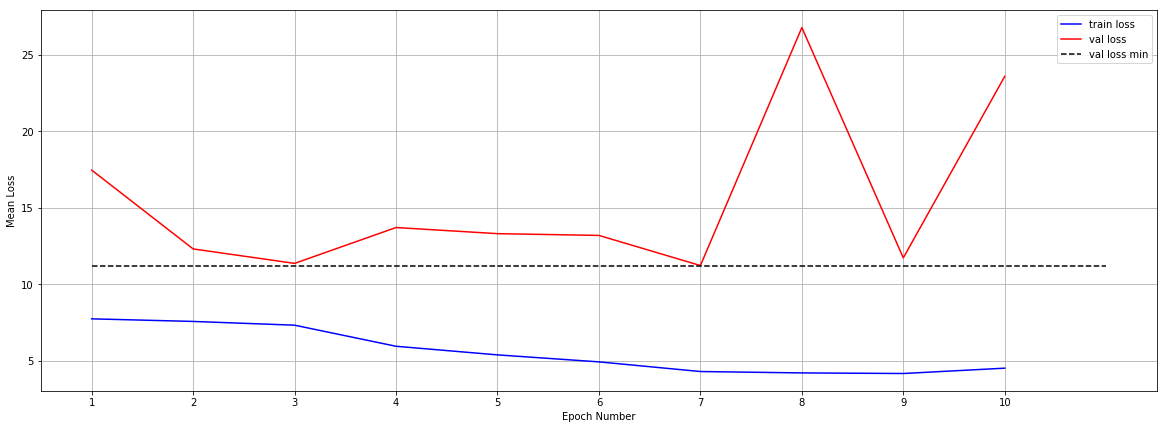

In [164]:
loss_array = np.array(loss_history)
train_loss = loss_array[:,0]
val_loss = loss_array[:,1]

x = np.arange(1,loss_array.shape[0]+1)
y = train_loss
plt.plot(x,y,c='blue',label='train loss')

x = np.arange(1,loss_array.shape[0]+1)
y = val_loss
plt.plot(x,y,c='red',label='val loss')

x0 = np.array([1,loss_array.shape[0]+1])
y0 = np.array([val_loss_min,val_loss_min])
plt.plot(x0,y0,c='black',label='val loss min',linestyle='--')

plt.grid(which='both') 
plt.legend()
fig,ax = plt.gcf(),plt.gca()
ax.set_xticks(x)
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Mean Loss')

fig.set_size_inches(20,7)

## Load best model

In [119]:
model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)
model.load_state_dict(torch.load(save_path))

## Test

In [120]:
names = 'train val test'.split()
data_list = [train_data,val_data,test_data]

for name,data in zip(names,data_list):
    eval_loss = []
    num_correct = 0
    to_eval = test_data
    for sentence, label in data:
        model.eval()

        vec = make_bow_vector(sentence, word_to_idx)
        target = torch.LongTensor([label])

        log_probs = model(vec)
        pred = log_probs.argmax().detach().numpy()
        correct = int(pred == label)
        num_correct += correct
        loss = loss_function(log_probs, target)

        eval_loss.append(loss.item())
    
    mean_loss = np.mean(eval_loss)
    print(f'----{name} set----'.upper())
    print(f'{name} loss of {round(mean_loss,3)}')
    print(f'{name} accuracy of {round(num_correct*100/len(data),2)}')


----TRAIN SET----
train loss of 2.586
train accuracy of 94.3
----VAL SET----
val loss of 11.223
val accuracy of 86.8
----TEST SET----
test loss of 11.698
test accuracy of 86.28


## Model Parameters

In [121]:
params = []
for p in model.parameters():
    print(p)
    a = p.detach().numpy()
    params.append(a)

Parameter containing:
tensor([[-1.2569e+00,  5.8442e-01,  6.3990e-04,  ..., -1.2295e+00,
         -1.3739e+00,  1.0188e-01],
        [ 1.2569e+00, -5.9037e-01,  2.6365e-03,  ...,  1.2283e+00,
          1.3738e+00, -9.7687e-02]], requires_grad=True)
Parameter containing:
tensor([ 3.5600, -3.5567], requires_grad=True)


In [122]:
a = params[0][1]

In [123]:
a.shape

(79201,)

In [124]:
sorted_idx = a.argsort()

In [125]:
for idx in sorted_idx[:10]:
    print(idx_to_word[idx],round(a[idx],3))

waste -34.175
worst -33.696
worse -32.117
poorly -29.207
dull -28.112
awful -27.925
lame -27.41
disappointing -25.683
annoying -23.434
disappointment -23.007


In [126]:
for idx in sorted_idx[-10:]:
    print(idx_to_word[idx],round(a[idx],3))

enjoyed 18.183
superb 18.589
excellent 18.733
incredible 18.77
enjoyable 18.843
noir 19.365
rare 20.779
surprisingly 20.863
today 21.136
perfect 22.556


In [131]:
examples = [(sentence,label) for sentence,label in train_data if 'waste' in sentence]

In [136]:
def show_text(example):
    sentence,label = example
    print(f'label is {idx_to_label[label]}'.upper())
    print('----------------------------------------')
    print(''.join(f'{w} ' for w in sentence))

In [137]:
show_text(examples[8])

LABEL IS NEGATIVE
----------------------------------------
you 've been fouled and beaten up in submission by my harsh statements about femme fatale '' `` guns n ' gals '' movies ! now comes another eed in disappointing rediscoveries : ninja movies ! many of these i 've seen before , and let me tell you , they are n't all that 's cracked up to be ! they usually do n't stick to the point . this , among all others , suffers from no originality ! what 's a ninja got to do with preventing a nuclear holocaust in russia ? and is n't this supposed to be a `` martial arts '' movie , too ? does plenty of gunfire sound like an incredible action movie to you ? is blood the number one reason to love this to death ? will you waste some of your hardearned cash over a lady singing in her seethrough tank top ? the answers to these important questions are found in the ninja mission , which should be in the martial arts section of your video store . for even more nonsense ninja fun , try checking out th

In [138]:
len(examples)

790

In [139]:
sum([label for _,label in examples])

60